#### Gradient-weighted class activation mapping (Grad-CAM)

In [52]:


class GradCAM:
    def __init__(self, model, target_layer, num_patches=14):
        self.model = model
        self.target_layer = target_layer
        self.num_patches = num_patches
        self.gradients = None
        self.activations = None
        self.hook_layers()

    def hook_layers(self):
        def forward_hook(module, input, output):
            self.activations = output

        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0]


        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def generate_cam(self, input_image, target_class=None):
        self.model.eval()
        output = self.model(input_image)

        if target_class is None:
            target_class = torch.argmax(output)

        self.model.zero_grad()
        one_hot_output = torch.zeros((1, output.size()[-1]), dtype=torch.float32).to(output.device)
        one_hot_output[0][target_class] = 1
        output.backward(gradient=one_hot_output)

        gradients = self.gradients.cpu().data.numpy()[0]
        activations = self.activations.cpu().data.numpy()[0]

        # Remove the class token and reshape the patch tokens back into spatial dimensions
        gradients = gradients[1:, :]
        activations = activations[1:, :]

        gradients = gradients.reshape(self.num_patches, self.num_patches, -1)
        activations = activations.reshape(self.num_patches, self.num_patches, -1)

        # Compute the weighted sum of activations
        weights = np.mean(gradients, axis=(0, 1))
        cam = np.zeros(activations.shape[:2], dtype=np.float32)

        for i, w in enumerate(weights):
            cam += w * activations[:, :, i]

        cam = np.maximum(cam, 0)
        cam = cv2.resize(cam, (input_image.size(2), input_image.size(3)))
        cam -= np.min(cam)
        cam /= np.max(cam)
        return cam

def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0)
    return image

def show_cam_on_image(img, mask):
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    return np.uint8(255 * cam)


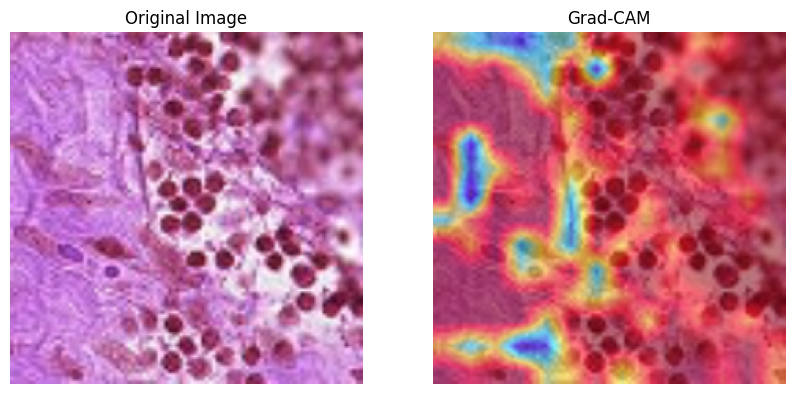

In [61]:

testImgPath =  '/histopathologic-cancer-detection/train/0005b379f09025d6a505756ff95ed2d875e39cd5.tif'
# Load and preprocess the image
image_path = testImgPath


input_image = preprocess_image(image_path).to(device)

# Initialize the Grad-CAM object with the model and target layer
target_layer = model1.model.blocks[-1].norm1
grad_cam = GradCAM(model1, target_layer)

# Generate the CAM

mask = grad_cam.generate_cam(input_image)

# Load the original image for visualization
original_image = cv2.imread(image_path)
original_image = cv2.resize(original_image, (224, 224))
original_image = np.float32(original_image) / 255

# Overlay the CAM on the original image
cam_image = show_cam_on_image(original_image, mask)

# Plot the original and CAM image
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(original_image)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Grad-CAM")
plt.imshow(cam_image)
plt.axis('off')
plt.show()

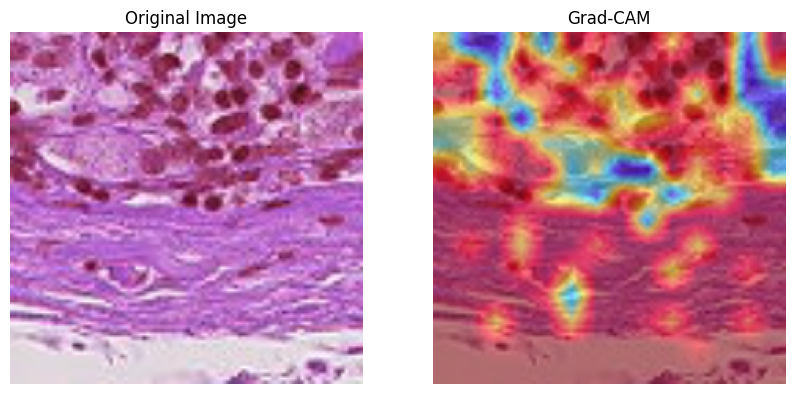

In [16]:

testImgPath =  '/histopathologic-cancer-detection/test/003f84a8dbe13f4fa549a510a5906187b34e2209.tif'
image_path = testImgPath


input_image = preprocess_image(image_path).to(device)
target_layer = model1.model.blocks[-1].norm1
grad_cam = GradCAM(model1, target_layer)

# Generate the CAM

mask = grad_cam.generate_cam(input_image)


original_image = cv2.imread(image_path)
original_image = cv2.resize(original_image, (224, 224))
original_image = np.float32(original_image) / 255


cam_image = show_cam_on_image(original_image, mask)

# Plot the original and CAM image
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(original_image)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Grad-CAM")
plt.imshow(cam_image)
plt.axis('off')
plt.show()

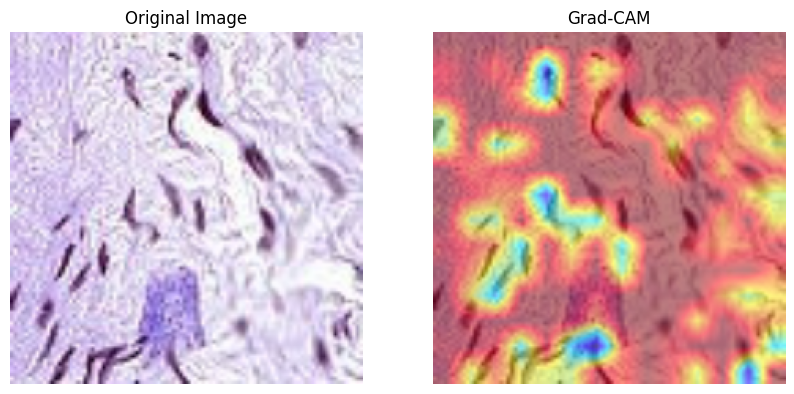

In [17]:

testImgPath =  '/histopathologic-cancer-detection/test/00429bc22cb1a4e5ce75660f930ddfa6a9e3461c.tif'

image_path = testImgPath


input_image = preprocess_image(image_path).to(device)

target_layer = model1.model.blocks[-1].norm1
grad_cam = GradCAM(model1, target_layer)

# Generate the CAM

mask = grad_cam.generate_cam(input_image)

original_image = cv2.imread(image_path)
original_image = cv2.resize(original_image, (224, 224))
original_image = np.float32(original_image) / 255

cam_image = show_cam_on_image(original_image, mask)


plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(original_image)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Grad-CAM")
plt.imshow(cam_image)
plt.axis('off')
plt.show()